In [1]:
import mmcci

In [2]:
visium_samples = [
    mmcci.io.read_CCIData('../data/melanoma/visium1.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/visium2.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/visium3.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/visium4.pkl'),
    ]

xenium_samples = [
    mmcci.io.read_CCIData('../data/melanoma/xenium1.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium2.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium3.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium4.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium5.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium6.pkl'),
    ]

cosmx_samples = [
    mmcci.io.read_CCIData('../data/melanoma/cosmx1.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx2.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx3.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx4.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx5.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx6.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx7.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx8.pkl'),
    ]

In [3]:
# These colours will be used for plotting later

colors = {
    'Endothelial': '#1f77b4',
    'Fibroblast': '#aec7e8',
    'KC Differentiating': '#ff7f0e',
    'KC Cycling': '#ffbb78',
    'KC Basal': '#2ca02c',
    'KC Other': '#98df8a',
    'NK + T': '#d62728',
    'B + PDC': '#ff9896',
    'Melanocyte': '#9467bd',
    'Myeloid': '#c5b0d5',
    'Pilosebaceous': '#8c564b',
    'NotDet': '#c49c94'
    }

In [4]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
}

visium_samples = [sample.rename_cell_types(cell_type_replacements) for sample in visium_samples]
cosmx_samples = [sample.rename_cell_types(cell_type_replacements) for sample in cosmx_samples]

#### Integrate within tech

In [5]:
for i in range(len(visium_samples)):
    visium_samples[i] = visium_samples[i].scale_by_nspots()
    visium_samples[i] = visium_samples[i].filter_by_p_vals(assay='scaled')
    visium_samples[i] = visium_samples[i].calc_overall(assay='filtered')
    
for i in range(len(xenium_samples)):
    xenium_samples[i] = xenium_samples[i].scale_by_nspots()
    xenium_samples[i] = xenium_samples[i].filter_by_p_vals(assay='scaled')
    xenium_samples[i] = xenium_samples[i].calc_overall(assay='filtered')
    
for i in range(len(cosmx_samples)):
    cosmx_samples[i] = cosmx_samples[i].scale_by_nspots()
    cosmx_samples[i] = cosmx_samples[i].filter_by_p_vals(assay='scaled')
    cosmx_samples[i] = cosmx_samples[i].calc_overall(assay='filtered')
    
visium = mmcci.it.lr_integration(visium_samples, method='>=50%', assay='scaled', metadata={'platform': 'visium'})
xenium = mmcci.it.lr_integration(xenium_samples, method='>=50%', assay='scaled', metadata={'platform': 'xenium'})
cosmx = mmcci.it.lr_integration(cosmx_samples, method='>=50%', assay='scaled', metadata={'platform': 'cosmx'})

Integrating p values: 100%|██████████| 517/517 [00:14<00:00, 35.27it/s]


Integrating p values: 100%|██████████| 1540/1540 [00:27<00:00, 55.27it/s]


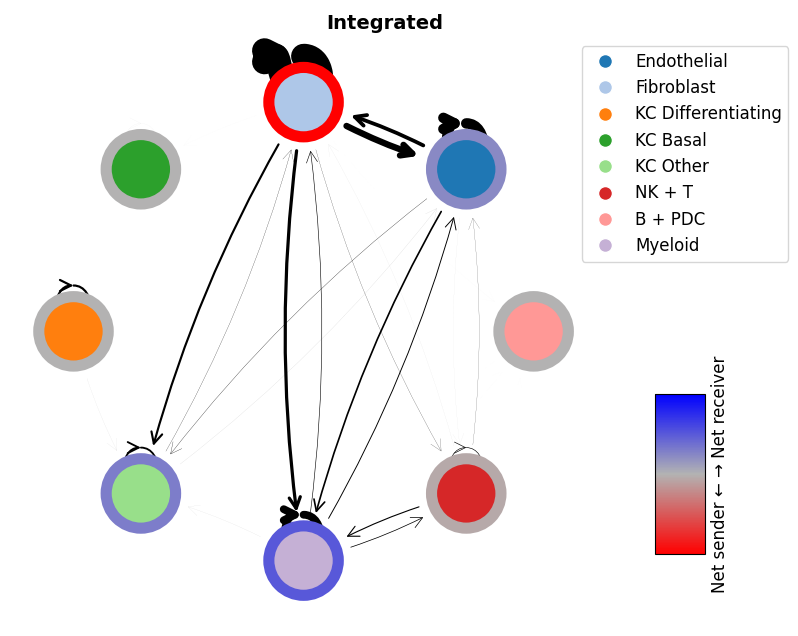

In [6]:
scale_factors = mmcci.it.calc_scale_factors([visium, xenium, cosmx])

visium = visium.scale(scale_factors['visium'])
xenium = xenium.scale(scale_factors['xenium'])
cosmx = cosmx.scale(scale_factors['cosmx'])

integrated = mmcci.it.lr_integration([visium, xenium, cosmx], method='>=50%')
integrated = integrated.filter_by_p_vals().calc_overall(assay='filtered')

mmcci.plt.network_plot(integrated.assays['filtered']['overall'], node_colors=colors, title='Integrated')

#### Get LR pairs from Fibroblast to Endothelial

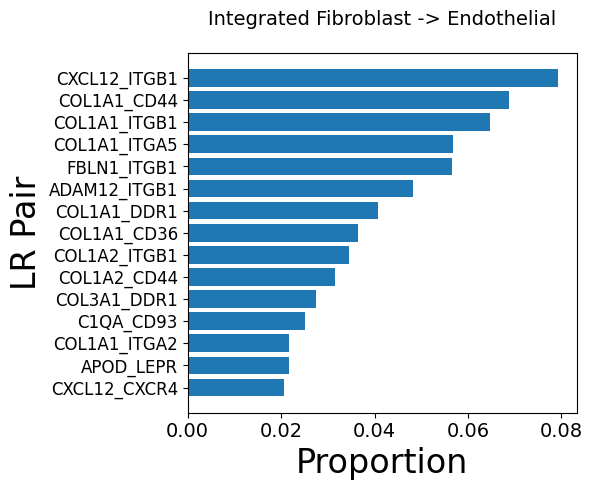

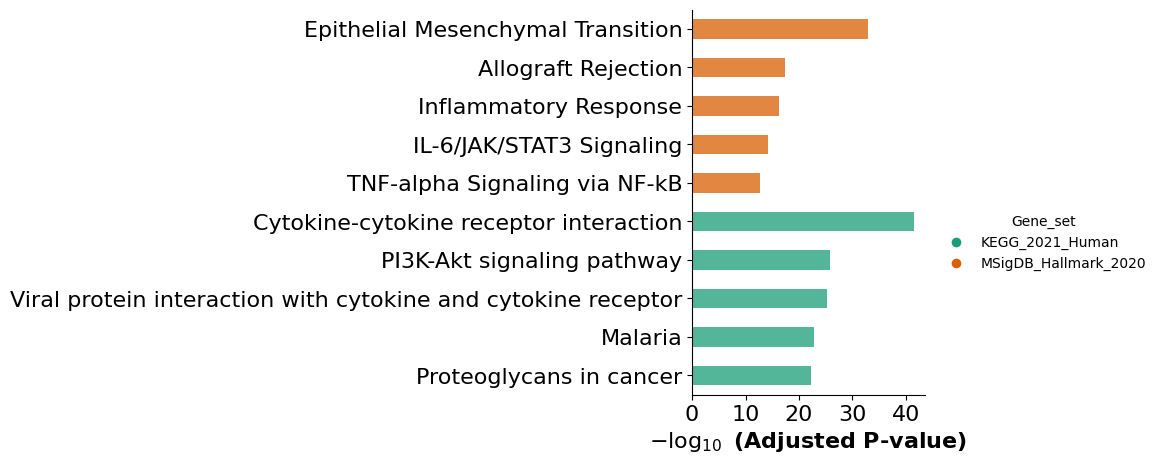

In [7]:
mmcci.plt.lrs_per_celltype(integrated, "Fibroblast", "Endothelial", title='Integrated Fibroblast -> Endothelial')
mmcci.an.run_gsea(integrated, lrs=integrated.get_lr_proportions("Fibroblast", "Endothelial", assay='filtered'), return_results=False)

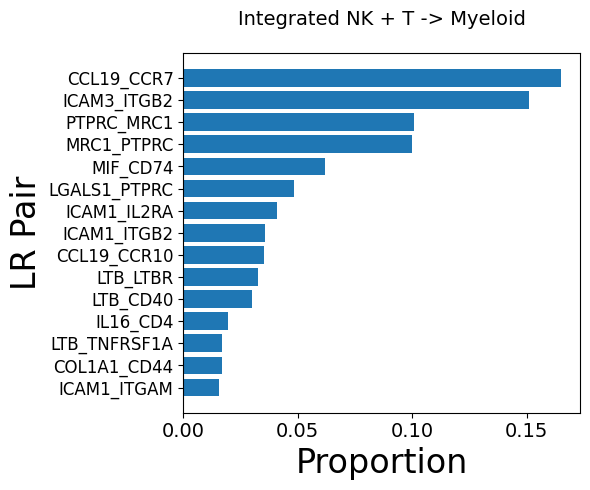

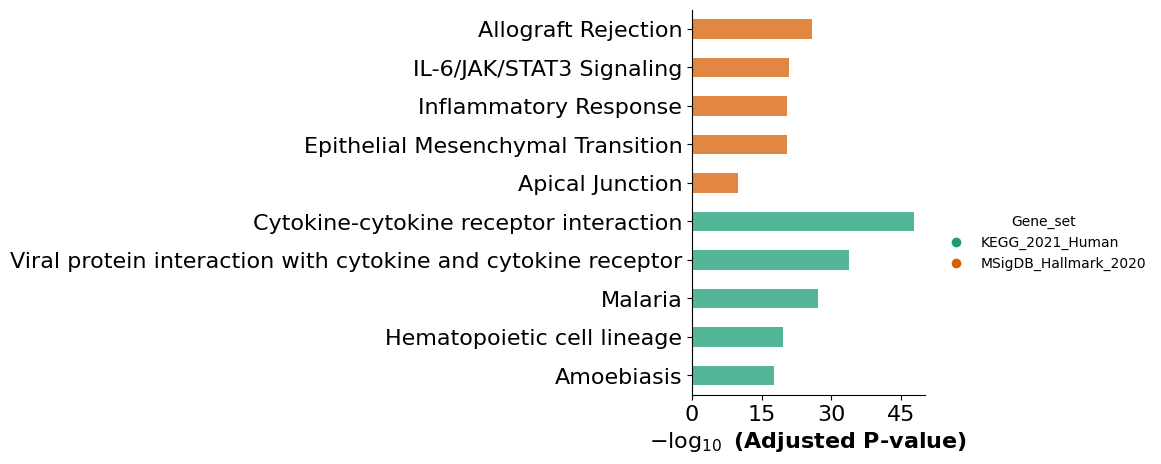

In [8]:
mmcci.plt.lrs_per_celltype(integrated, "NK + T", "Myeloid", title='Integrated NK + T -> Myeloid')
mmcci.an.run_gsea(integrated, lrs=integrated.get_lr_proportions("NK + T", "Myeloid", assay='filtered'), return_results=False)

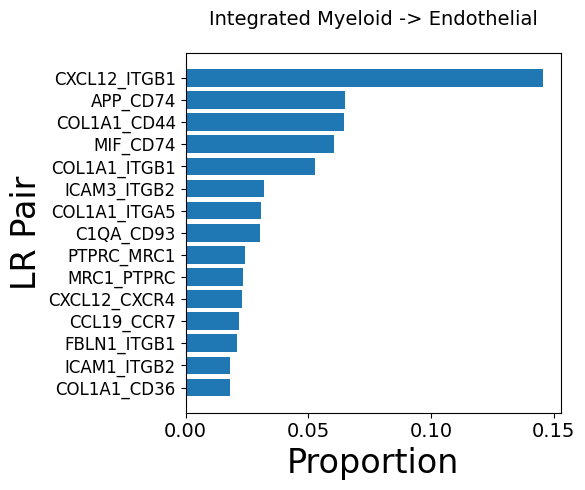

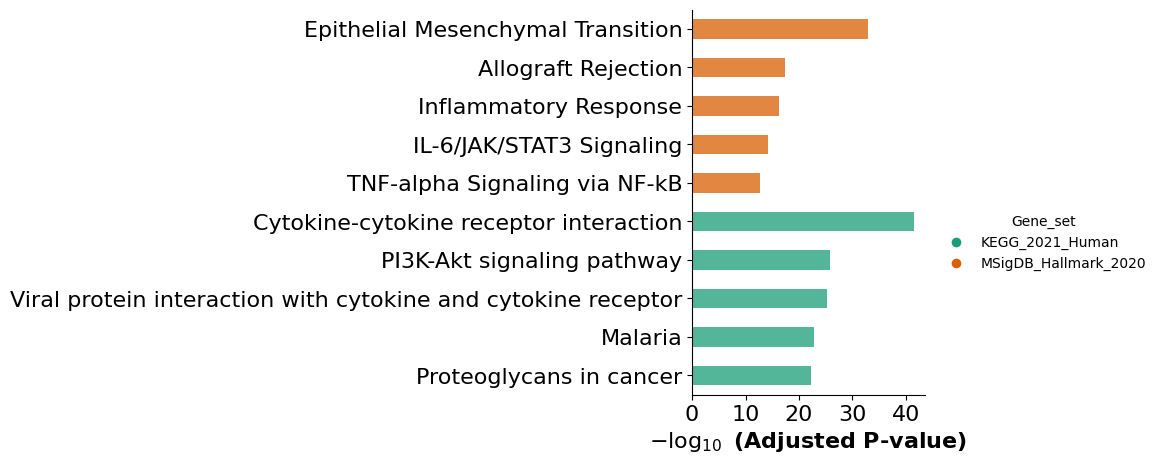

In [9]:
mmcci.plt.lrs_per_celltype(integrated, "Myeloid", "Endothelial", title='Integrated Myeloid -> Endothelial')
mmcci.an.run_gsea(integrated, lrs=integrated.get_lr_proportions("Myeloid", "Endothelial", assay='filtered'), return_results=False)

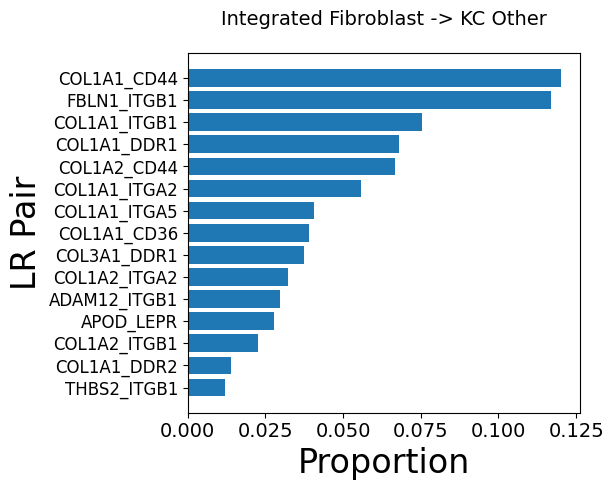

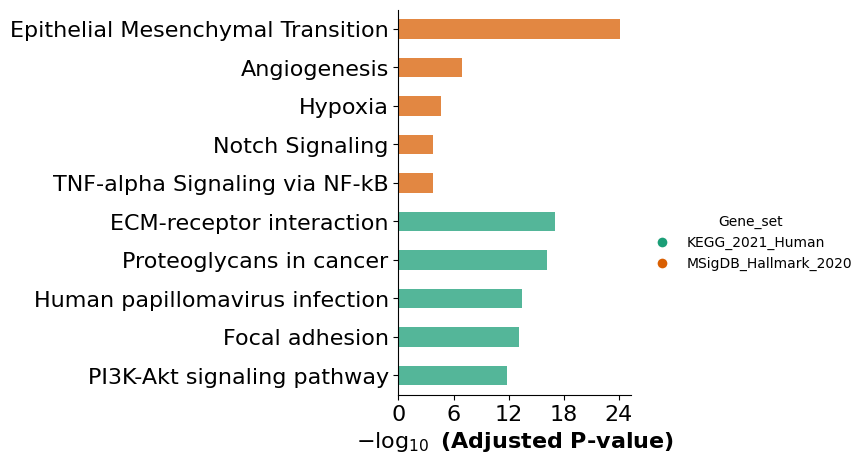

In [10]:
mmcci.plt.lrs_per_celltype(integrated, "Fibroblast", "KC Other", title='Integrated Fibroblast -> KC Other')
mmcci.an.run_gsea(integrated, lrs=integrated.get_lr_proportions("Fibroblast", "KC Other", assay='filtered'), return_results=False)

#### Find interactions involved in specific pathways

In [ ]:
results = mmcci.an.run_gsea(integrated, assay="filtered", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"], show_barplot=False)

Number of interactions in emt: 21


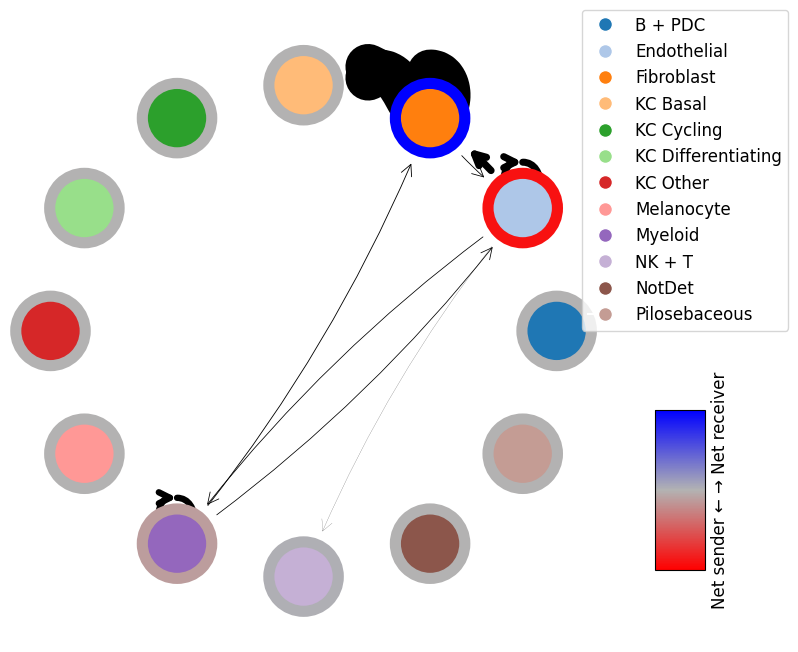

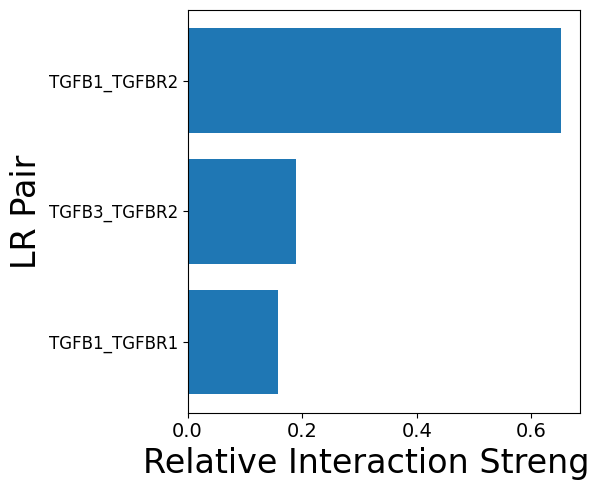

In [ ]:
integrated = mmcci.an.pathway_subset(integrated, assay="filtered", gsea_results=results, terms=["TGF-beta signaling pathway"], strict=True, assay_name="TGFB")
mmcci.plt.network_plot(integrated.assays["TGFB"]["overall"], remove_unconnected=False)

mmcci.plt.lr_barplot(integrated, assay="TGFB", n=3)

Number of interactions in EMT: 35


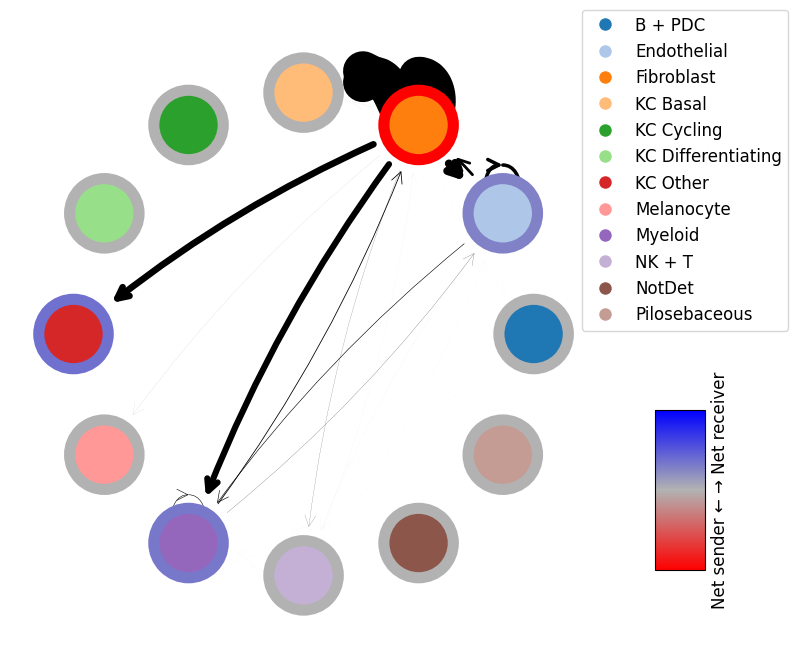

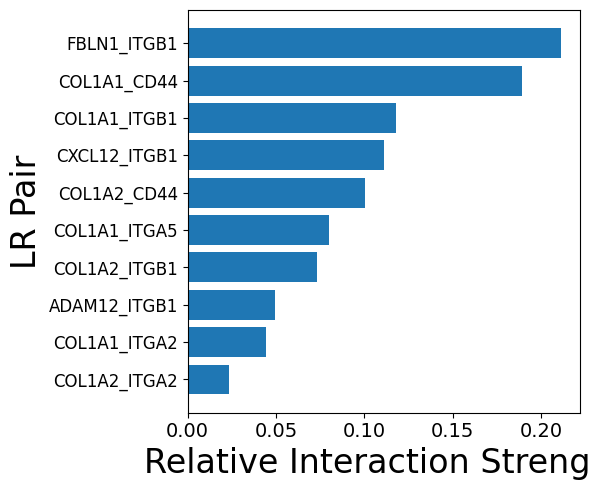

In [15]:
integrated = mmcci.an.pathway_subset(integrated, assay="filtered", gsea_results=results, terms=["Epithelial Mesenchymal Transition"], strict=True, assay_name="EMT")
mmcci.plt.network_plot(integrated.assays["EMT"]["overall"], remove_unconnected=False)

mmcci.plt.lr_barplot(integrated, assay="EMT", n=10)

Number of interactions in PI3K: 64


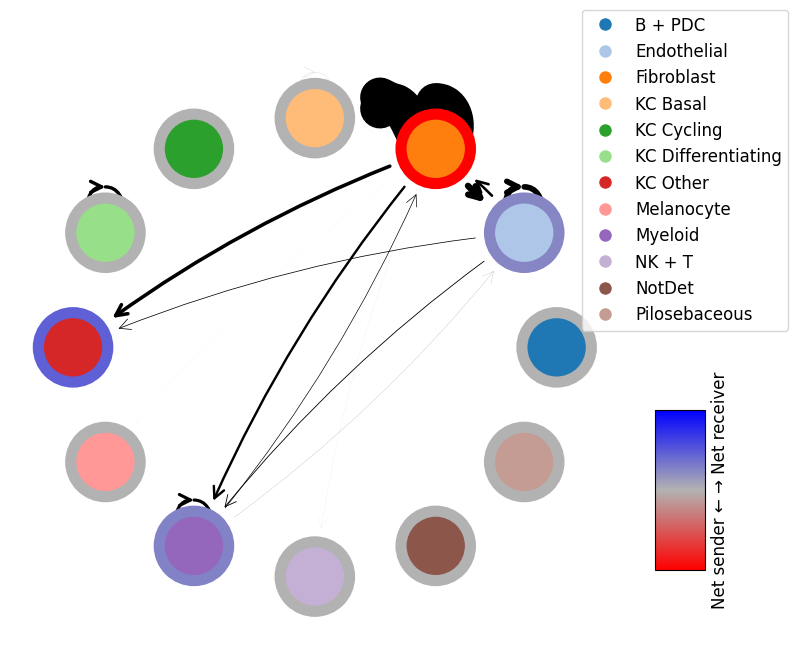

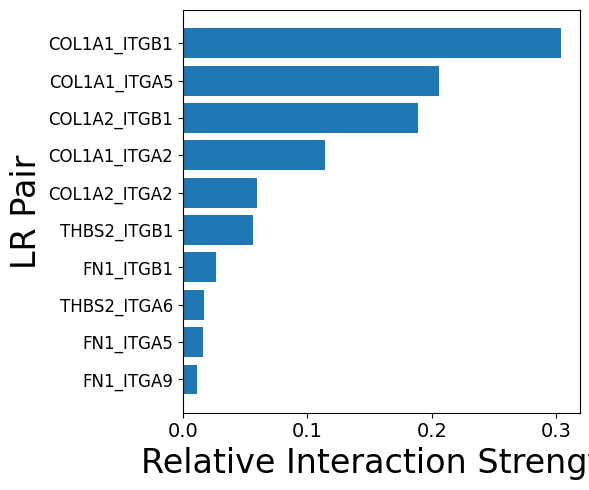

In [16]:
integrated = mmcci.an.pathway_subset(integrated, assay="filtered", gsea_results=results, terms=["PI3K-Akt signaling pathway"], strict=True, assay_name="PI3K")
mmcci.plt.network_plot(integrated.assays["PI3K"]["overall"], remove_unconnected=False)

mmcci.plt.lr_barplot(integrated, assay="PI3K", n=10)